# Mess3 generator smoke test

This notebook builds a simple `mess3` hidden Markov model and prints a few generated symbols.


In [1]:
# pyright: reportMissingImports=false
import jax

from simplexity.generative_processes.builder import build_hidden_markov_model

# Instantiate mess3 with defaults from config (x=0.15, a=0.6)
model = build_hidden_markov_model("mess3", x=0.15, a=0.6)

# Initial belief state: use the model's normalizing_eigenvector as a valid distribution
state = model.normalizing_eigenvector[None, :]

# Generate a short sequence
key = jax.random.PRNGKey(0)[None, :]
sequence_len = 10
final_state, observations = model.generate(state, key, sequence_len, False)

print("Generated observations:", observations.squeeze().tolist())


Generated observations: [0, 2, 0, 2, 2, 0, 0, 1, 2, 1]


In [2]:
# pyright: reportMissingImports=false
# Generate again but keep all intermediate belief states (priors)
states_per_step, obs = model.generate(state, key, sequence_len, True)

# Normalize belief states to probabilities per step
beliefs = jax.vmap(model.normalize_belief_state)(states_per_step.squeeze(0))

for t, (o, b) in enumerate(zip(obs.squeeze(0).tolist(), beliefs.tolist())):
	print(f"t={t:02d} obs={o} belief={b}")


t=00 obs=0 belief=[0.3333333432674408, 0.3333333432674408, 0.3333333432674408]
t=01 obs=2 belief=[0.6000000238418579, 0.20000000298023224, 0.20000000298023224]
t=02 obs=0 belief=[0.31578949093818665, 0.17105263471603394, 0.5131579041481018]
t=03 obs=2 belief=[0.5894569158554077, 0.14816294610500336, 0.2623802125453949]
t=04 obs=2 belief=[0.2984992265701294, 0.145717591047287, 0.555783212184906]
t=05 obs=0 belief=[0.16437214612960815, 0.12040877342224121, 0.7152190804481506]
t=06 obs=0 belief=[0.4870404005050659, 0.14601799845695496, 0.36694154143333435]
t=07 obs=1 belief=[0.6828927993774414, 0.12545859813690186, 0.19164860248565674]
t=08 obs=2 belief=[0.365500271320343, 0.456887811422348, 0.17761191725730896]
t=09 obs=1 belief=[0.23474085330963135, 0.26835331320762634, 0.4969058632850647]


In [5]:
# pyright: reportMissingImports=false
import itertools
import importlib
import simplexity.generative_processes.builder as builder

# Ensure we see latest symbols if the module changed in this session
builder = importlib.reload(builder)

# Build a product of two mess3 generators
prod_model = builder.build_product_hidden_markov_model(
	process_names=["mess3", "mess3"],
	process_kwargs=[{"x": 0.15, "a": 0.6}, {"x": 0.2, "a": 0.5}],
)

# Initial state for the product model
prod_state = prod_model.normalizing_eigenvector[None, :]

# Generate a few steps and print observations as tuples and beliefs
prod_final_state, prod_obs = prod_model.generate(prod_state, key, sequence_len, False)

# Decode product observations back to tuples for readability
vocab_sizes = [3, 3]

def unravel_index(idx: int, dims: list[int]) -> tuple[int, ...]:
	coords = []
	for d in reversed(dims):
		coords.append(idx % d)
		idx //= d
	return tuple(reversed(coords))

obs_tuples = [unravel_index(int(o), vocab_sizes) for o in prod_obs.squeeze(0).tolist()]
print("Product observations (tuples):", obs_tuples)

# Now with all states and beliefs
prod_states_per_step, prod_obs_all = prod_model.generate(prod_state, key, sequence_len, True)
prod_beliefs = jax.vmap(prod_model.normalize_belief_state)(prod_states_per_step.squeeze(0))

for t, (o, b) in enumerate(zip(prod_obs_all.squeeze(0).tolist(), prod_beliefs.tolist())):
	print(f"t={t:02d} obs={unravel_index(int(o), vocab_sizes)} belief_dim={len(b)}")


Product observations (tuples): [(0, 1), (2, 2), (0, 0), (2, 0), (2, 1), (0, 2), (0, 1), (1, 1), (2, 0), (1, 1)]
t=00 obs=(0, 1) belief_dim=9
t=01 obs=(2, 2) belief_dim=9
t=02 obs=(0, 0) belief_dim=9
t=03 obs=(2, 0) belief_dim=9
t=04 obs=(2, 1) belief_dim=9
t=05 obs=(0, 2) belief_dim=9
t=06 obs=(0, 1) belief_dim=9
t=07 obs=(1, 1) belief_dim=9
t=08 obs=(2, 0) belief_dim=9
t=09 obs=(1, 1) belief_dim=9


In [6]:
# pyright: reportMissingImports=false
import jax.numpy as jnp

# For mess3 components, each has 3 hidden states
state_sizes = [3, 3]

# beliefs over joint space: shape (T, prod(state_sizes)) already computed as prod_beliefs

def factor_marginals(belief_1d: jnp.ndarray, dims: list[int]) -> list[jnp.ndarray]:
	"""Return per-component marginal beliefs from a joint belief vector."""
	tensor = belief_1d.reshape(dims)
	margs: list[jnp.ndarray] = []
	for i in range(len(dims)):
		axes = tuple(ax for ax in range(len(dims)) if ax != i)
		margs.append(tensor.sum(axis=axes))
	return margs

print("First 5 timesteps of beliefs (joint vs. factored marginals):")
for t in range(min(5, prod_beliefs.shape[0])):
	joint = prod_beliefs[t]
	m1, m2 = factor_marginals(joint, state_sizes)
	print(
		f"t={t:02d} joint_len={joint.shape[0]} marg1={jnp.round(m1, 3).tolist()} marg2={jnp.round(m2, 3).tolist()}"
	)


First 5 timesteps of beliefs (joint vs. factored marginals):
t=00 joint_len=9 marg1=[0.3330000042915344, 0.3330000042915344, 0.3330000042915344] marg2=[0.3330000042915344, 0.3330000042915344, 0.3330000042915344]
t=01 joint_len=9 marg1=[0.6000000238418579, 0.20000000298023224, 0.20000000298023224] marg2=[0.25, 0.5, 0.25]
t=02 joint_len=9 marg1=[0.3160000145435333, 0.17100000381469727, 0.5130000114440918] marg2=[0.23100000619888306, 0.30800002813339233, 0.4620000123977661]
t=03 joint_len=9 marg1=[0.5890000462532043, 0.14800000190734863, 0.26200002431869507] marg2=[0.4520000219345093, 0.25, 0.2980000078678131]
t=04 joint_len=9 marg1=[0.2980000078678131, 0.14600001275539398, 0.5560000538825989] marg2=[0.5520000457763672, 0.21700000762939453, 0.23100000619888306]


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_46188/4017367257.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm_joint = cm.get_cmap("viridis")
/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_46188/4017367257.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm_resid = cm.get_cmap("coolwarm")


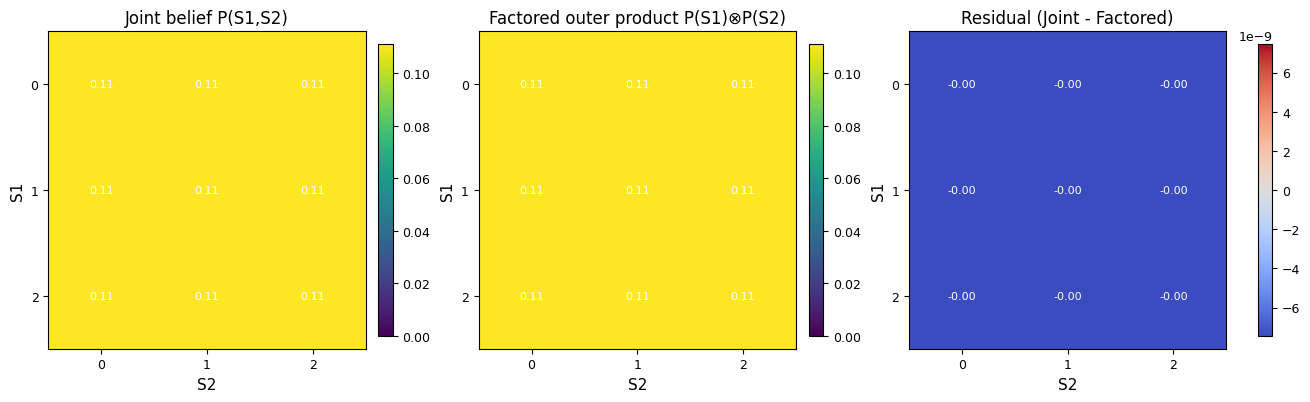

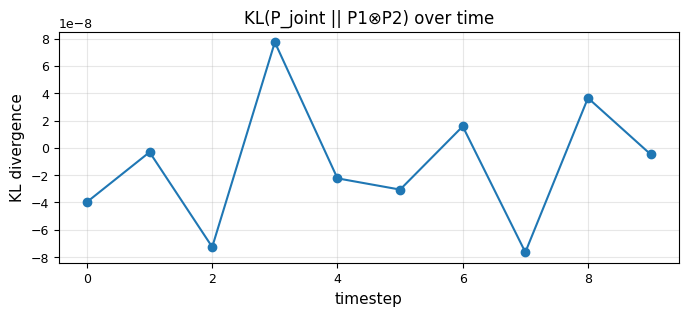

In [9]:
# pyright: reportMissingImports=false
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm, Normalize
import jax.numpy as jnp

plt.rcParams.update({
	"figure.figsize": (12, 4),
	"axes.titlesize": 12,
	"axes.labelsize": 11,
	"xtick.labelsize": 9,
	"ytick.labelsize": 9,
})

# Only supports 2 components for the heatmap view
assert len(state_sizes) == 2, "Heatmap viz assumes two components"

cm_joint = cm.get_cmap("viridis")
cm_resid = cm.get_cmap("coolwarm")


def outer_from_marginals(marginals: list[np.ndarray]) -> np.ndarray:
	mat = np.outer(marginals[0], marginals[1])
	return mat


def plot_belief_triptych(joint_vec: np.ndarray, dims: list[int], annotate: bool = False):
	m1, m2 = factor_marginals(jnp.asarray(joint_vec), dims)
	J = joint_vec.reshape(dims)
	F = outer_from_marginals([np.asarray(m1), np.asarray(m2)])
	R = J - F

	vmax = max(J.max(), F.max())
	rmax = np.max(np.abs(R))

	fig, axes = plt.subplots(1, 3, figsize=(13, 4), constrained_layout=True)
	for ax, data, title, cmap, norm in [
		(axes[0], J, "Joint belief P(S1,S2)", cm_joint, Normalize(vmin=0, vmax=vmax)),
		(axes[1], F, "Factored outer product P(S1)⊗P(S2)", cm_joint, Normalize(vmin=0, vmax=vmax)),
		(axes[2], R, "Residual (Joint - Factored)", cm_resid, TwoSlopeNorm(vcenter=0, vmin=-rmax, vmax=rmax)),
	]:
		im = ax.imshow(data, cmap=cmap, norm=norm)
		ax.set_xlabel("S2")
		ax.set_ylabel("S1")
		ax.set_xticks(range(dims[1]))
		ax.set_yticks(range(dims[0]))
		ax.set_title(title)
		cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
		if annotate:
			for i in range(dims[0]):
				for j in range(dims[1]):
					ax.text(j, i, f"{data[i, j]:.2f}", ha="center", va="center", fontsize=8, color="white" if np.abs(data[i, j]) > (norm.vmax if hasattr(norm, 'vmax') else rmax)/2 else "black")
	return fig


def kl_divergence(p: np.ndarray, q: np.ndarray, eps: float = 1e-12) -> float:
	p = p.astype(float)
	q = q.astype(float)
	p = np.clip(p, eps, 1.0)
	q = np.clip(q, eps, 1.0)
	p /= p.sum()
	q /= q.sum()
	return float(np.sum(p * (np.log(p) - np.log(q))))


def plot_factorization_error_over_time(beliefs: np.ndarray, dims: list[int]):
	kls: list[float] = []
	for t in range(beliefs.shape[0]):
		m1, m2 = factor_marginals(jnp.asarray(beliefs[t]), dims)
		factored = outer_from_marginals([np.asarray(m1), np.asarray(m2)]).reshape(-1)
		kls.append(kl_divergence(beliefs[t], factored))
	fig, ax = plt.subplots(1, 1, figsize=(8, 3))
	ax.plot(kls, marker="o", lw=1.5)
	ax.set_title("KL(P_joint || P1⊗P2) over time")
	ax.set_xlabel("timestep")
	ax.set_ylabel("KL divergence")
	ax.grid(True, alpha=0.3)
	return fig

# Demo for a single timestep (e.g., t=0) and the time series of errors
_ = plot_belief_triptych(prod_beliefs[0], state_sizes, annotate=True)
_ = plot_factorization_error_over_time(prod_beliefs, state_sizes)



In [ ]:
# pyright: reportMissingImports=false
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.patches import Polygon

# Example non-uniform marginals for illustration
m1 = np.array([0.7, 0.2, 0.1])
m2 = np.array([0.2, 0.5, 0.3])
J = np.outer(m1, m2)

# 2-simplex (equilateral triangle) utilities
tri_verts = np.array([
	[0.0, 0.0],
	[1.0, 0.0],
	[0.5, math.sqrt(3) / 2.0],
])


def barycentric_to_cartesian(p: np.ndarray) -> np.ndarray:
	return p[0] * tri_verts[0] + p[1] * tri_verts[1] + p[2] * tri_verts[2]


def draw_simplex(ax, labels=("s0", "s1", "s2")):
	poly = Polygon(tri_verts, closed=True, fill=False, linewidth=1.5, edgecolor="black")
	ax.add_patch(poly)
	ax.plot(tri_verts[:, 0], tri_verts[:, 1], alpha=0)  # set limits via plotted points
	ax.text(*(tri_verts[0] - np.array([0.05, -0.05])), labels[0], fontsize=11)
	ax.text(*(tri_verts[1] + np.array([0.02, -0.05])), labels[1], fontsize=11)
	ax.text(*(tri_verts[2] + np.array([0.0, 0.03])), labels[2], fontsize=11)
	ax.set_aspect("equal")
	ax.set_xticks([])
	ax.set_yticks([])
	ax.set_xlim(-0.1, 1.1)
	ax.set_ylim(-0.1, math.sqrt(3) / 2.0 + 0.1)


def plot_simplex_point(ax, p: np.ndarray, color="tab:blue"):
	xy = barycentric_to_cartesian(p)
	ax.scatter([xy[0]], [xy[1]], s=120, color=color, zorder=5, edgecolors="white", linewidth=1.0)
	return xy

fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# Left: Belief S1 on simplex
ax1 = axes[0]
draw_simplex(ax1, labels=("S1=0", "S1=1", "S1=2"))
plot_simplex_point(ax1, m1, color="tab:green")
ax1.set_title("Belief over S1 (simplex)")

# Middle: Belief S2 on simplex
ax2 = axes[1]
draw_simplex(ax2, labels=("S2=0", "S2=1", "S2=2"))
plot_simplex_point(ax2, m2, color="tab:orange")
ax2.set_title("Belief over S2 (simplex)")

# Right: Joint (factored outer product) heatmap
ax3 = axes[2]
vmax = float(J.max())
im = ax3.imshow(J, cmap=cm.get_cmap("viridis"), norm=Normalize(vmin=0, vmax=vmax))
ax3.set_xticks(range(3))
ax3.set_yticks(range(3))
ax3.set_xlabel("S2")
ax3.set_ylabel("S1")
ax3.set_title("Factored joint P(S1)⊗P(S2)")
fig.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)

# Add big operator annotations
fig.suptitle("Producted vs. Factored Beliefs", fontsize=14, y=1.03)
fig.text(0.345, 0.50, "⊗", fontsize=28, ha="center", va="center")
fig.text(0.515, 0.50, "→", fontsize=24, ha="center", va="center")

# Save to outputs
os.makedirs("outputs", exist_ok=True)
fig.savefig("outputs/product_vs_factored_diagram.svg", bbox_inches="tight")
fig.savefig("outputs/product_vs_factored_diagram.png", dpi=200, bbox_inches="tight")

plt.show()
